### Урок 5. Задача оттока: варианты постановки, возможные способы решения##

### Домашнее задание

1. Для нашего пайплайна поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix

from sklearn.model_selection import GridSearchCV

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers 

df = pd.read_csv("churn_data.csv")

df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
# распределение классов

df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'])

### 1. Для нашего пайплайна поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']

continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [7]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

In [8]:
feats = FeatureUnion(final_transformers)

In [9]:
models_results = {
    'Model' : [],
    'Precision' : [],
    'Recall' : [],
    'F-Score' : [],
    'Roc-Auc' : []
}

### RandomForest

In [10]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier()),
])

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [12]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.06, 0.69, 0.03, 0.1 , 0.07, 0.06, 0.28, 0.54, 0.04, 0.18])

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:,1])
print(f"Roc auc score: {roc_auc}")

Best Threshold=0.400000, F-Score=0.593, Precision=0.631, Recall=0.559
Roc auc score: 0.8341476292009341


In [14]:
models_results['Model'].append('RandomForest')
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['F-Score'].append(fscore[ix])
models_results['Roc-Auc'].append(roc_auc)

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1857  153]
 [ 222  268]]


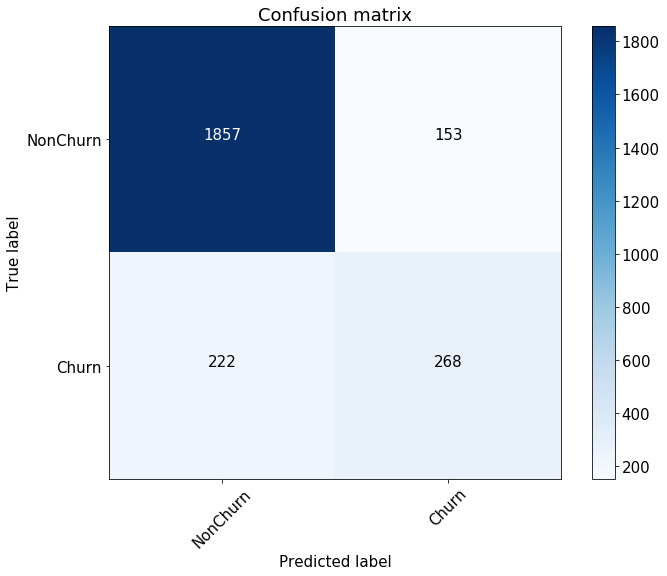

In [16]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### GradientBoosting

In [17]:
pipeline_gb = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier()),
])

pipeline_gb.fit(X_train, y_train)

preds = pipeline_gb.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09227166, 0.54356687, 0.04415509, 0.12827751, 0.04949845,
       0.03988735, 0.10800395, 0.58973411, 0.12583823, 0.40696349])

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=pipeline_gb.predict_proba(X_test)[:,1])
print(f"Roc auc score: {roc_auc}")

Best Threshold=0.358017, F-Score=0.614, Precision=0.655, Recall=0.578
Roc auc score: 0.8533287643415575


In [19]:
models_results['Model'].append('GradientBoosting')
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['F-Score'].append(fscore[ix])
models_results['Roc-Auc'].append(roc_auc)

Confusion matrix, without normalization
[[1861  149]
 [ 209  281]]


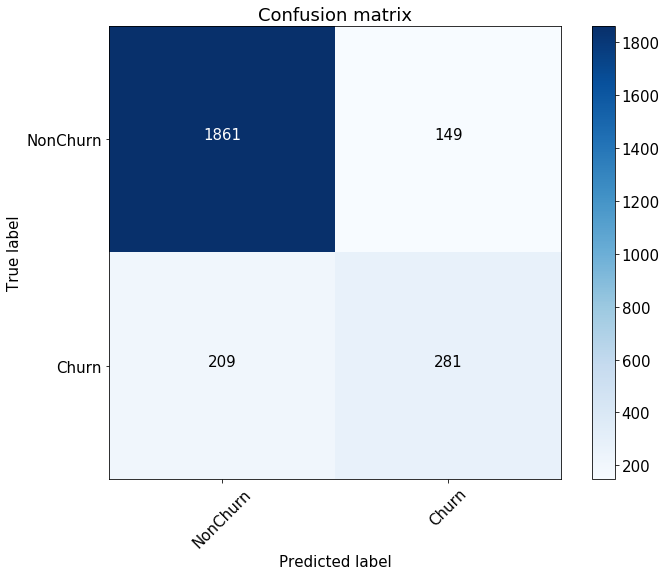

In [20]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_gb = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_gb, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### LogisticRegression

In [21]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression()),
])

pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.18773468, 0.48355693, 0.06656233, 0.13992454, 0.10879202,
       0.07794468, 0.34296056, 0.30337183, 0.16265321, 0.28164485])

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:,1])
print(f"Roc auc score: {roc_auc}")

Best Threshold=0.278517, F-Score=0.481, Precision=0.434, Recall=0.541
Roc auc score: 0.7512630723931364


In [23]:
models_results['Model'].append('LogisticRegression')
models_results['Precision'].append(precision[ix])
models_results['Recall'].append(recall[ix])
models_results['F-Score'].append(fscore[ix])
models_results['Roc-Auc'].append(roc_auc)

Confusion matrix, without normalization
[[1664  346]
 [ 226  264]]


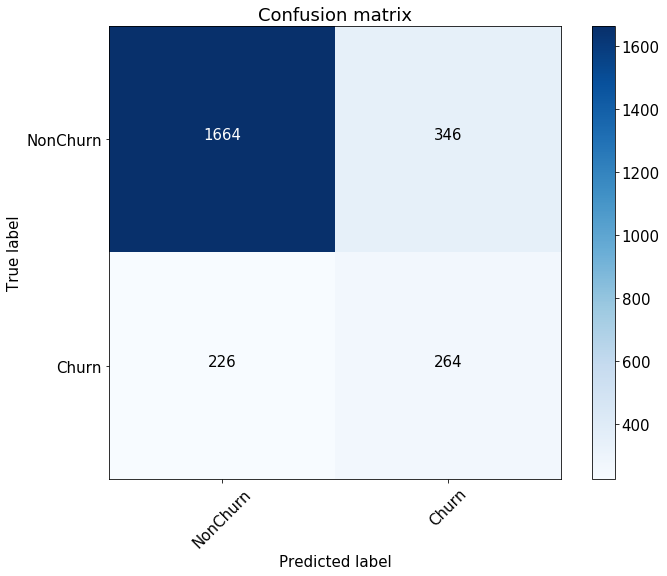

In [24]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [25]:
pd.DataFrame(data=models_results).sort_values('Precision', ascending=False)

,Model,Precision,Recall,F-Score,Roc-Auc
1,GradientBoosting,0.655093,0.577551,0.613883,0.853329
0,RandomForest,0.631336,0.559184,0.593074,0.834148
2,LogisticRegression,0.433715,0.540816,0.481381,0.751263


У логистической регрессии самые низкие метрики. Ее мы сразу отбрасываем.

У градиентного бустинга метрики лучше, чем у случайного леса.

Принимаем градиентный бустинг.

Для данной задачи наиболее подходящая DS-метрика - точность.

Количество клиентов, не в оттоке, сильно превышает количество кандидатов на отток. При попытке поймать несколько дополнительных кандидатов на отток, есть вероятность сильно увеличить количество ложноположительных результатов.

При данной экономической модели (1 доллар - затраты на удержание, 2 доллара - прибыль с каждого правильно классифицированного (True Positive) удержанного) экономически целесообразнее ориентираваться на точность (коммуникация с FP может стоить дорого).

При других входных параметрах ориентация на полноту могла бы быть обоснована, например, если бы расходы на удержание были бы ниже, или если бы каждый удержанный пользователь приносил больше прибыли.

### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты

In [26]:
cnf_matrix_gb

array([[1861,  149],
       [ 209,  281]])

In [27]:
retention_cost = 1
retention_profit = 2

profit = cnf_matrix_gb[1][1] * retention_profit
print(f'Прибыль, которую принесут удержанные клиенты: {profit}$')

cost = (cnf_matrix_gb[1][1] + cnf_matrix_gb[0][1]) * retention_cost
print(f'Затраты на удержание клиентов: {cost}$')

net_profit = profit - cost
print(f'Чистая прибыль, после вычета затрат на удержание: {net_profit}$')

Прибыль, которую принесут удержанные клиенты: 562$
Затраты на удержание клиентов: 430$
Чистая прибыль, после вычета затрат на удержание: 132$


### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [28]:
params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

In [29]:
grid = GridSearchCV(pipeline_gb,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.3,
 'classifier__min_samples_leaf': 2}

In [30]:
pipeline_gb = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(max_depth=None, max_features=0.3, 
                                          min_samples_leaf=2)),
])
pipeline_gb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [31]:
preds = pipeline_gb.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.179730, F-Score=0.596, Precision=0.645, Recall=0.553


Confusion matrix, without normalization
[[1861  149]
 [ 220  270]]


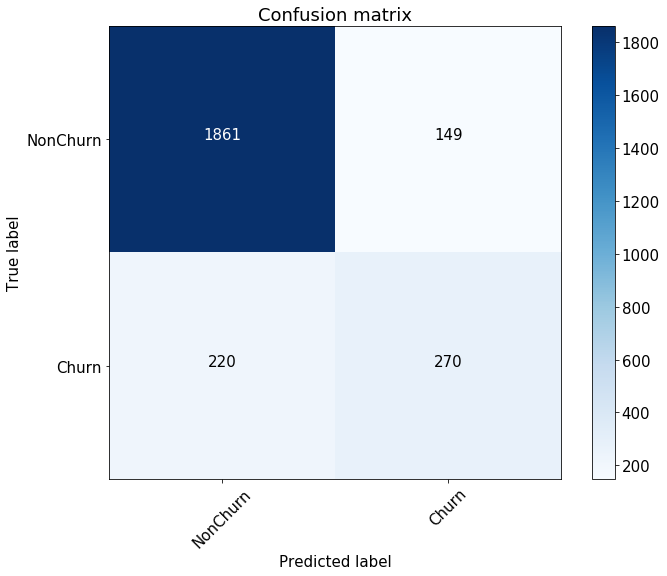

In [32]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Полученные результаты оказались даже чуть хуже, чем до поиска гиперпараметров. Возможно, те параметры, которые могли бы улучшить результат, не были включены в сетку с параметрами.

### 5. (опционально) Еще раз провести оценку экономической эффективности

In [33]:
retention_cost = 1
retention_profit = 2

profit = cnf_matrix[1][1] * retention_profit
print(f'Прибыль, которую принесут удержанные клиенты: {profit}$')

cost = (cnf_matrix[1][1] + cnf_matrix[0][1]) * retention_cost
print(f'Затраты на удержание клиентов: {cost}$')

net_profit = profit - cost
print(f'Чистая прибыль, после вычета затрат на удержание: {net_profit}$')

Прибыль, которую принесут удержанные клиенты: 540$
Затраты на удержание клиентов: 419$
Чистая прибыль, после вычета затрат на удержание: 121$


Полученные результаты оказались даже чуть хуже, чем до поиска гиперпараметров. Возможно, те параметры, которые могли бы улучшить результат, не были включены в сетку с параметрами.